### <span style="color:#00aba1;"> Requirements </span>


In [4]:
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
from numpy import shape
sys.path.append('C:\\Users\\Admin\\Desktop\\Tese\\Code')
import functions as fc
import importlib
importlib.reload(fc)
import ANN
import csv
import numpy as np
importlib.reload(ANN)
import joblib


### <span style="color:#00aba1;"> Data preprocessing </span>


#### Loading data:

In [5]:
#Upload training set
TRAIN_X = pd.read_csv("C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\x_train.csv", index_col="ID")
TRAIN_Y = pd.read_csv("C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\y_train.csv", index_col="ID")

#Upload testing set

TEST_X = pd.read_csv("C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\x_test.csv", index_col="ID")
TEST_Y = pd.read_csv("C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\y_test.csv", index_col="ID")


In [6]:
#Create index and columns
train_x_index = TRAIN_X.index
train_x_columns = TRAIN_X.columns

train_y_index = TRAIN_Y.index
train_y_columns = TRAIN_Y.columns

test_x_index = TEST_X.index
test_x_columns = TEST_X.columns

test_y_index = TEST_Y.index
test_y_columns = TEST_Y.columns

#### Scaling training data:

In [7]:
scaler_x = StandardScaler()
scaler_x.fit(TRAIN_X)
train_x_scaled = pd.DataFrame(scaler_x.transform(TRAIN_X), index=train_x_index, columns=train_x_columns)


scaler_y = StandardScaler()
scaler_y.fit(TRAIN_Y)
train_y_scaled = pd.DataFrame(scaler_y.transform(TRAIN_Y),index=train_y_index,columns=train_y_columns)

#### Scaling testing data:

In [8]:
test_x_scaled = pd.DataFrame(scaler_x.transform(TEST_X), index=test_x_index, columns=test_x_columns)

test_y_scaled = pd.DataFrame(scaler_y.transform(TEST_Y),index=test_y_index,columns=test_y_columns)

#### Transforming data into arrays:

In [9]:
train_y_as_array = TRAIN_Y.values.ravel()
test_y_as_array = TEST_Y.values.ravel()

train_y_scaled_as_array = train_y_scaled.values.ravel()
test_y_scaled_as_array = test_y_scaled.values.ravel()

train_x_as_array = TRAIN_X.values.ravel()
test_x_as_array = TEST_X.values.ravel()

train_x_scaled_as_array = train_x_scaled.values.ravel()
test_x_scaled_as_array = test_x_scaled.values.ravel()

### <span style="color:#00aba1;"> Feature Selection </span>


#### Creating subsets:

In [10]:
features_pca = fc.create_pca_features(n_components=8, 
                                      train_x_scaled=train_x_scaled,
                                      columns=train_x_columns,
                                      train_x=TRAIN_X)

features_anova = fc.create_anova_features(k_features=17,
                                          train_x=TRAIN_X,
                                          train_y=TRAIN_Y,
                                          train_x_columns=train_x_columns)

features_lasso = fc.create_lasso_features(cv=8,
                                          max_iter=100000,
                                          train_x_scaled=train_x_scaled,
                                          train_y_array=train_y_as_array,
                                          train_x_columns=train_x_columns,
                                          train_x=TRAIN_X)

features_correlation = fc.create_correlation_features(train_x=TRAIN_X,
                                                      correlation_threshold=0.6)

features_rfe = fc.create_RFE_features(n_features_to_select=17,
                                      train_x_scaled=train_x_scaled,
                                      train_y_scaled_array=train_y_scaled_as_array,
                                      train_x=TRAIN_X)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [11]:
features_lasso = pd.DataFrame(columns=["Bio_1_2","Sugar_1_2","Volume","CW","No carbon source used","GP","SNO","RO","Final_day","C/N_1_2","diff_Sugar_0_to_1_2","GrowthRate","CarbonConsumptionRate","SpecificRateOfNaNO3Consumption"])

#### Figures for feature selection:

In [12]:
# # PCA
# fc.plot_of_the_cumulative_sum_of_eigenvalues(train_x_scaled=train_x_scaled,
#                                              type_of_experience="Regression",
#                                              number_of_case=1,
#                                              save="y")

# # ANOVA
# fc.plot_ANOVA_F_values(train_x=TRAIN_X,
#                        train_y_array=train_y_as_array,
#                        train_x_columns=train_x_columns,
#                        type_of_experience="Regression",
#                        number_of_case=1,
#                        save="y")

# # LASSO
# fc.plot_lasso_coef_values(cv=5,
#                           max_iter=10000,
#                           train_x_scaled=train_x_scaled,
#                           train_y_array=train_y_as_array,
#                           train_x_columns=train_x_columns,
#                           type_of_experience="Regression",
#                           number_of_case=1,
#                           save="y")

# #RFE
# fc.plot_RFE_ranking(train_x_columns=train_x_columns,
#                     n_features_to_select=17,
#                     train_x_scaled=train_x_scaled,
#                     train_y_scaled_array=train_y_scaled_as_array,
#                     type_of_experience="Regression",
#                     number_of_case=1,
#                     save="y"
#                     )

#### Initial Conditions:

In [13]:
cv = LeaveOneOut()

scoring = {
    "MSE" : mean_squared_error,
    "MAE": mean_absolute_error
}

features = {
    "features_pca": features_pca,
    "features_anova": features_anova,
    "features_lasso": features_lasso,
    "features_correlation": features_correlation,
    "features_rfe": features_rfe,
    "all_features": TRAIN_X
}

### <span style="color:#00aba1;"> Grid Search </span>


#### Validation split:

In [41]:
x_val_train, x_val_test,y_val_train, y_val_test = train_test_split(TRAIN_X,TRAIN_Y,test_size=0.18,random_state=42)
x_val_train_scaled, x_val_test_scaled,y_val_train_scaled, y_val_test_scaled = train_test_split(train_x_scaled,train_y_scaled,test_size=0.18,random_state=42)

In [42]:
y_val_train_as_array = y_val_train.values.ravel()
y_val_test_as_array = y_val_test.values.ravel()

y_val_train_scaled_as_array = y_val_train_scaled.values.ravel()
y_val_test_scaled_as_array = y_val_test_scaled.values.ravel()

x_val_train_as_array = x_val_train.values.ravel()
x_val_test_as_array = x_val_test.values.ravel()

x_val_train_scaled_as_array = x_val_train_scaled.values.ravel()
x_val_test_scaled_as_array = x_val_test_scaled.values.ravel()


#### Grid Search RF:

In [43]:
# # GridSearch for RF

# for subset in features:

#     features_selected = features[subset]

#     x = x_val_train[features_selected.columns]
#     x_val_test_for_search = x_val_test[features_selected.columns]

#     dict_search = fc.search_ML(
#         dict_param=fc.RFR_param,
#         algorithm=RandomForestRegressor,
#         x_val_train=x,
#         y_val_train=y_val_train_as_array, 
#         x_val_test = x_val_test_for_search,
#         y_val_test = y_val_test,
#         train_y_index=train_y_index,
#         train_y_columns=train_y_columns,
#         scaler=scaler_y,
#         train_y_as_array=y_val_train_as_array,
#         scoring=scoring,
#         mode="Regression",
#         subset= subset,
#         case=1,
#         regressor = "Random Forest",
#         scale=None,
#         checkpoint_file = f'checkpoint_{subset}.pkl'
#     )

#     output_file_path = f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\{subset}.csv"
#     if dict_search:
#         print(f"Writing results to {output_file_path}")
#         with open(output_file_path, "w", newline='') as f:
#             w = csv.writer(f)
#             w.writerow(["Parameters", "Scores"])  
#             for key, values in dict_search.items():
#                 w.writerow([key, values])
#     else:
#         print(f"No data to write for subset {subset}")

#### Grid Search SVR:

In [44]:
# # #Grid Search for SVR

# for subset in features:
#     features_selected = features[subset]
#     x = x_val_train_scaled[features_selected.columns]
#     x_val_test_for_search = x_val_test_scaled[features_selected.columns]
    
#     # Iterate over each kernel and accumulate the results
#     for kernel in ["poly", "rbf", "sigmoid", "linear"]:
#         dict_search = fc.search_ML(
#             dict_param=fc.SVR_param[kernel],
#             algorithm=SVR,
#             x_val_train=x,
#             y_val_train=y_val_train_scaled_as_array, 
#             x_val_test = x_val_test_for_search,
#             y_val_test = y_val_test_scaled,
#             train_y_index=y_val_test.index,
#             train_y_columns=y_val_test.columns,
#             scaler=scaler_y,
#             train_y_as_array=y_val_train_as_array,
#             scoring=scoring,
#             mode="Regression",
#             subset = subset,
#             case = 1,
#             regressor = "Support vector",
#             scale="y",
#             checkpoint_file = f'checkpoint_{subset}.pkl'
#         )


#     output_file_path = f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\{subset}.csv"
#     if dict_search:
#         print(f"Writing results to {output_file_path}")
#         with open(output_file_path, "w", newline='') as f:
#             w = csv.writer(f)
#             w.writerow(["Parameters", "Scores"])  
#             for key, values in dict_search.items():
#                 w.writerow([key, values])
#     else:
#         print(f"No data to write for subset {subset}")

#### Grid Search NN:

In [45]:
# ## Grid Search ANN
# NN_param = {
#     "optimizer": ["adam"],
#     "loss" : ["mae","mse"],
#     "activation":["relu"],
#     "layers_vector": [[64,32],
#                       [128,64],
#                       [128,64,32],
#                       [64,32,16],
#                       [128,64,32,16],
#                       [256,128,64,32],
#                       [64,32,16,4]],
#     "output_layer": [1,2,4,8],
#     "batch_size": [2,4,8]

# }



# for subset in features:

#     features_selected = features[subset]

#     x = x_val_train_scaled[features_selected.columns]
#     x_val_test_for_search = x_val_test_scaled[features_selected.columns]


#     grid = fc.stage_experiments(NN_param)

#     store = fc.load_checkpoint(f"checkpoint_file_{subset}.pkl")

#     print("Initial checkpoint data:", store)

#     count = 0

#     for experiment in grid:
#             args = [v[experiment[i]] for i, v in enumerate(NN_param.values())]
#             count += 1
#             print(f"Experiment {count}/{len(grid)}: {args}")
#             args_dict = {k: args[i] for i, k in enumerate(NN_param)}

#             if str(args_dict) in store:
#                 print(f"Skipping experiment {count}/{len(grid)} (already completed)")
#                 continue
#             else:
#                 try:
#                     model = ANN.NeuralNetworkModel(input_shape= [x.shape[1]],
#                                                     **args_dict)
#                     model.train_model(train_x = x,
#                     train_y = y_val_train_scaled,
#                     validation_split = 0.1,
#                     verbose=0,
#                     epochs = 100)
                
#                     model.load_model()
#                     args_str = fc.sanitize_args_dict(args_dict)
#                     model.save_model(case=1,subset=subset,args=args_str)
#                     y_val_test_pred_scaled = model.predict(test_x=x_val_test_for_search, verbose=1)
#                     y_val_test_pred_scaled = pd.DataFrame(y_val_test_pred_scaled) 
#                     y_val_test_pred = pd.DataFrame(scaler_y.inverse_transform(y_val_test_pred_scaled))

#                     for metric in scoring:
#                         value = scoring[metric](y_val_test,y_val_test_pred)
#                         if str(args_dict) not in store:
#                             store[str(args_dict)] = []
#                         store[str(args_dict)].append(value)
#                     print(f"Results for experiment {count}: {store[str(args_dict)]}")
#                     fc.save_checkpoint(store, f"checkpoint_file_{subset}.pkl")
#                 except Exception as e:
#                     store[str(args_dict)] = []
#                     fc.save_checkpoint(store, f"checkpoint_file_{subset}.pkl")
#                     print(f"Error encountered with args: {args_dict}")
#                     print(f"Exception: {e}")
#                     continue

#     output_file_path = f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\{subset}.csv"
#     if store:
#         print(f"Writing results to {output_file_path}")
#         with open(output_file_path, "w", newline='') as f:
#             w = csv.writer(f)
#             w.writerow(["Parameters", "Scores"])  
#             for key, values in store.items():
#                 w.writerow([key, values])
#     else:
#         print(f"No data to write for subset {subset}")

#### Search:

In [ ]:
# Search results
importlib.reload(fc)
results = fc.transform_csv_into_dict(
    "C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support Vector\\features_correlation.csv")
fc.get_best_param(results)

((('C', 0.1), ('epsilon', 0.001), ('gamma', 1), ('kernel', 'rbf')),
 2.85145541054585)

### <span style="color:#00aba1;"> Testing  </span>


#### Results:

In [14]:
neural_network = {
    "features_pca": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\features_pca_adam_mse_relu_[64, 32, 16, 4]_1_4.keras",
    "features_anova": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\features_anova_adam_mse_relu_[64, 32, 16]_2_8.keras",
    "features_lasso": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\features_lasso_adam_mse_relu_[256, 128, 64, 32]_2_2.keras",
    "features_correlation": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\features_correlation_adam_mse_relu_[64, 32, 16]_1_8.keras",
    "features_rfe": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\features_rfe_adam_mae_relu_[64, 32, 16]_8_8.keras",
    "all_features": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Neural Network\\all_features_adam_mae_relu_[128, 64, 32, 16]_1_4.keras"
}

random_forest = {
    "features_pca": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\features_pca_10_absolute_error_None_7_sqrt_True.pkl",
    "features_anova": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\features_anova_10_absolute_error_None_3_sqrt_True.pkl",
    "features_lasso": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\features_lasso_10_squared_error_None_5_sqrt_False.pkl",
    "features_correlation": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\features_correlation_1_squared_error_2_7_sqrt_True.pkl",
    "features_rfe": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\features_rfe_10_squared_error_None_5_log2_False.pkl",
    "all_features": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Random Forest\\all_features_10_squared_error_None_7_sqrt_True.pkl"
}

support_vector = {
    "features_pca": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\features_pca_rbf_0.001_1_0.1.pkl",
    "features_anova": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\features_anova_poly_2_0.001_0.01_0.1.pkl",
    "features_lasso": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\features_lasso_poly_4_0.001_0.01_20.pkl",
    "features_correlation": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\features_correlation_rbf_0.001_1_0.1.pkl",
    "features_rfe": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\features_rfe_poly_4_0.001_0.01_20.pkl",
    "all_features": f"C:\\Users\\Admin\\Desktop\\Tese\\47\\Experiences\\Regression\\Case_1\\GridSearch\\Support vector\\all_features_rbf_0.001_1_0.1.pkl"
}

In [29]:
results_test_RF = {}
results_test_ANN = {}
results_test_SVR = {}

y_pred_RF_test = {}
y_pred_ANN_test = {}
y_pred_SVR_test = {}

for subset in features:
    features_selected = features[subset]
    x_test = test_x_scaled[features_selected.columns]

    model = fc.load_model(support_vector[subset])
    y_pred_scaled = model.predict(x_test)

    y_pred_scaled = pd.DataFrame(y_pred_scaled, index=test_y_index, columns=test_y_columns)
    y_pred = pd.DataFrame(scaler_y.inverse_transform(y_pred_scaled), index=test_y_index, columns=test_y_columns)
    y_pred = y_pred.values.ravel()
    y_pred = np.array([max(0,x) for x in y_pred])
    y_pred_SVR_test[subset] = y_pred

    for metric in scoring:
        value = fc.get_scores(y_true=test_y_as_array, y_pred=y_pred, metric=scoring[metric])
        results_test_SVR[f"{subset}_{metric}"] = value

for subset in features:
    features_selected = features[subset]
    x_test = TEST_X[features_selected.columns]

    model = fc.load_model(random_forest[subset])
    y_pred = model.predict(x_test)
    y_pred = np.array([max(0,x) for x in y_pred])

    y_pred_RF_test[subset] = y_pred

    for metric in scoring:
        value = fc.get_scores(y_true=test_y_as_array, y_pred=y_pred, metric=scoring[metric])
        results_test_RF[f"{subset}_{metric}"] = value

for subset in features:
    features_selected = features[subset]
    x_test = test_x_scaled[features_selected.columns]

    model = ANN.NeuralNetworkModel(input_shape= [x_test.shape[1]],
                                   optimizer="adam",
                                   loss = "mse",
                                   activation="relu",
                                   layers_vector=[128,64,32,16],
                                   output_layer=10,
                                   batch_size = 5,)
    model.load_model(checkpoint_path=neural_network[subset])
    y_pred_scaled = model.predict(x_test)
    y_pred_scaled = pd.DataFrame(y_pred_scaled)
    y_pred = pd.DataFrame(scaler_y.inverse_transform(y_pred_scaled))
    y_pred.iloc[:,0] = y_pred.iloc[:,0].apply(lambda x: max(0,x))
    y_pred = y_pred.values.ravel()
    y_pred_ANN_test[subset] = y_pred

    for metric in scoring:
        value = fc.get_scores(y_true=test_y_as_array, y_pred=y_pred, metric=scoring[metric])
        results_test_ANN[f"{subset}_{metric}"] = value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [36]:
y_pred_SVR_test

{'features_pca': array([1.08812529, 1.55859602, 1.60732662, 1.58152018, 1.56915328,
        1.22560486, 1.55847659, 0.89539677, 1.90640549, 1.95852975]),
 'features_anova': array([1.48006799, 1.52158252, 1.5277608 , 1.53597775, 1.53983479,
        1.50191022, 1.51863546, 1.41869136, 1.51147027, 1.52794107]),
 'features_lasso': array([1.19466614, 1.30138271, 1.29204673, 1.33370202, 1.75710934,
        1.25314267, 1.29665545, 1.2291271 , 1.28926554, 1.32701829]),
 'features_correlation': array([1.41478893, 1.54022707, 1.67390844, 1.91394713, 1.58070988,
        1.24285713, 1.5046541 , 1.61079035, 1.76114457, 1.91977117]),
 'features_rfe': array([1.00528923, 1.34014648, 1.30461561, 1.44629606, 2.31315658,
        1.25018424, 1.28851894, 1.21367642, 1.30139219, 1.34786138]),
 'all_features': array([1.43549378, 1.53253928, 1.55100304, 1.55288874, 1.54104722,
        1.26652395, 1.53252747, 1.61339964, 1.88291497, 1.87797279])}

In [ ]:
y_pred_diff_models ={
    "Random forest using ANOVA features":([ 0.14  ,  7.1925,  5.244 , 10.163 ,  9.925 ,  3.3245,  2.001 ,
         0.5045,  4.623 ,  8.235 ]),
    "Neural network using correlation features": ([ 0.        ,  4.5963187 ,  3.119061  , 10.812322  , 10.002376  ,
         1.4291779 ,  0.59462225,  1.202089  ,  6.5636477 ,  8.520667  ]),
    "Support vector machine using correlation features": ([1.41478893, 1.54022707, 1.67390844, 1.91394713, 1.58070988,
        1.24285713, 1.5046541 , 1.61079035, 1.76114457, 1.91977117])    
    }


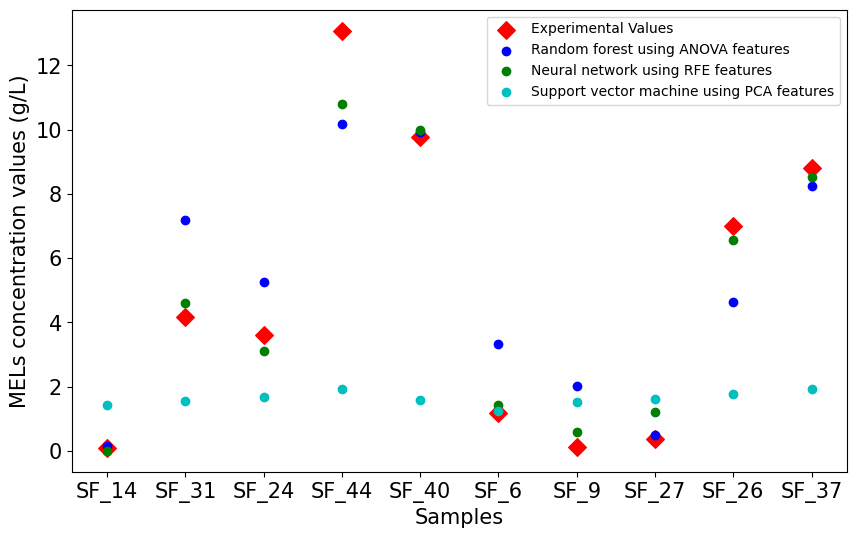

In [39]:
fc.plot_y_true_pred(true_y=TEST_Y,target="Mel_4",pred_y=y_pred_diff_models,model="",save="y")

#### Graphics:

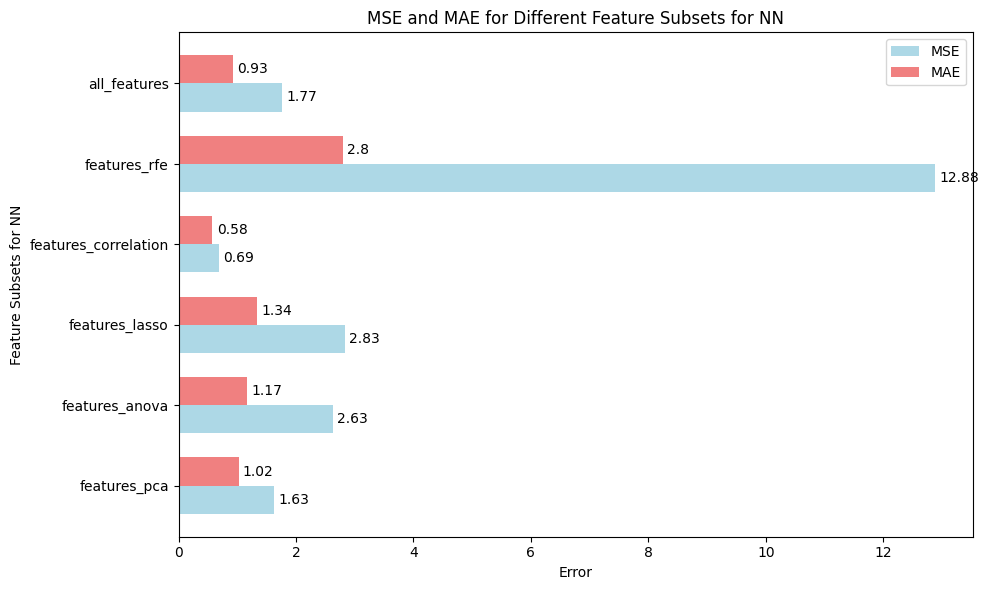

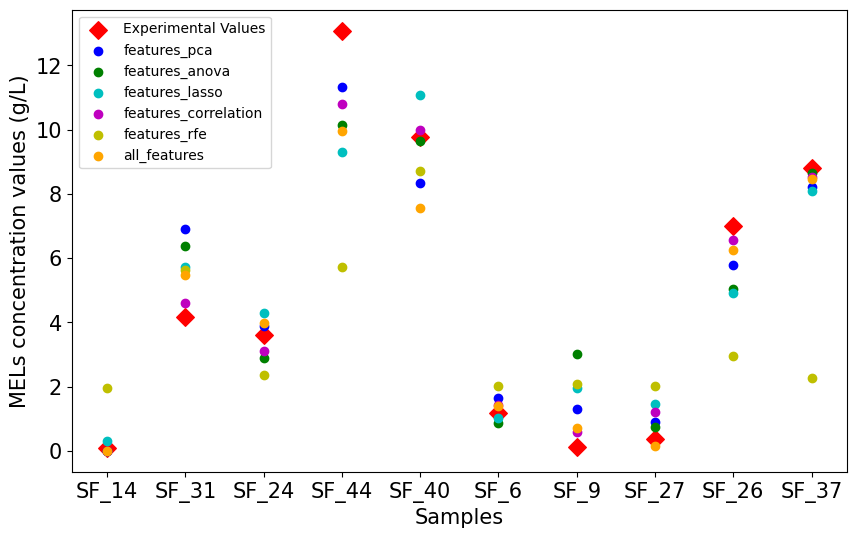

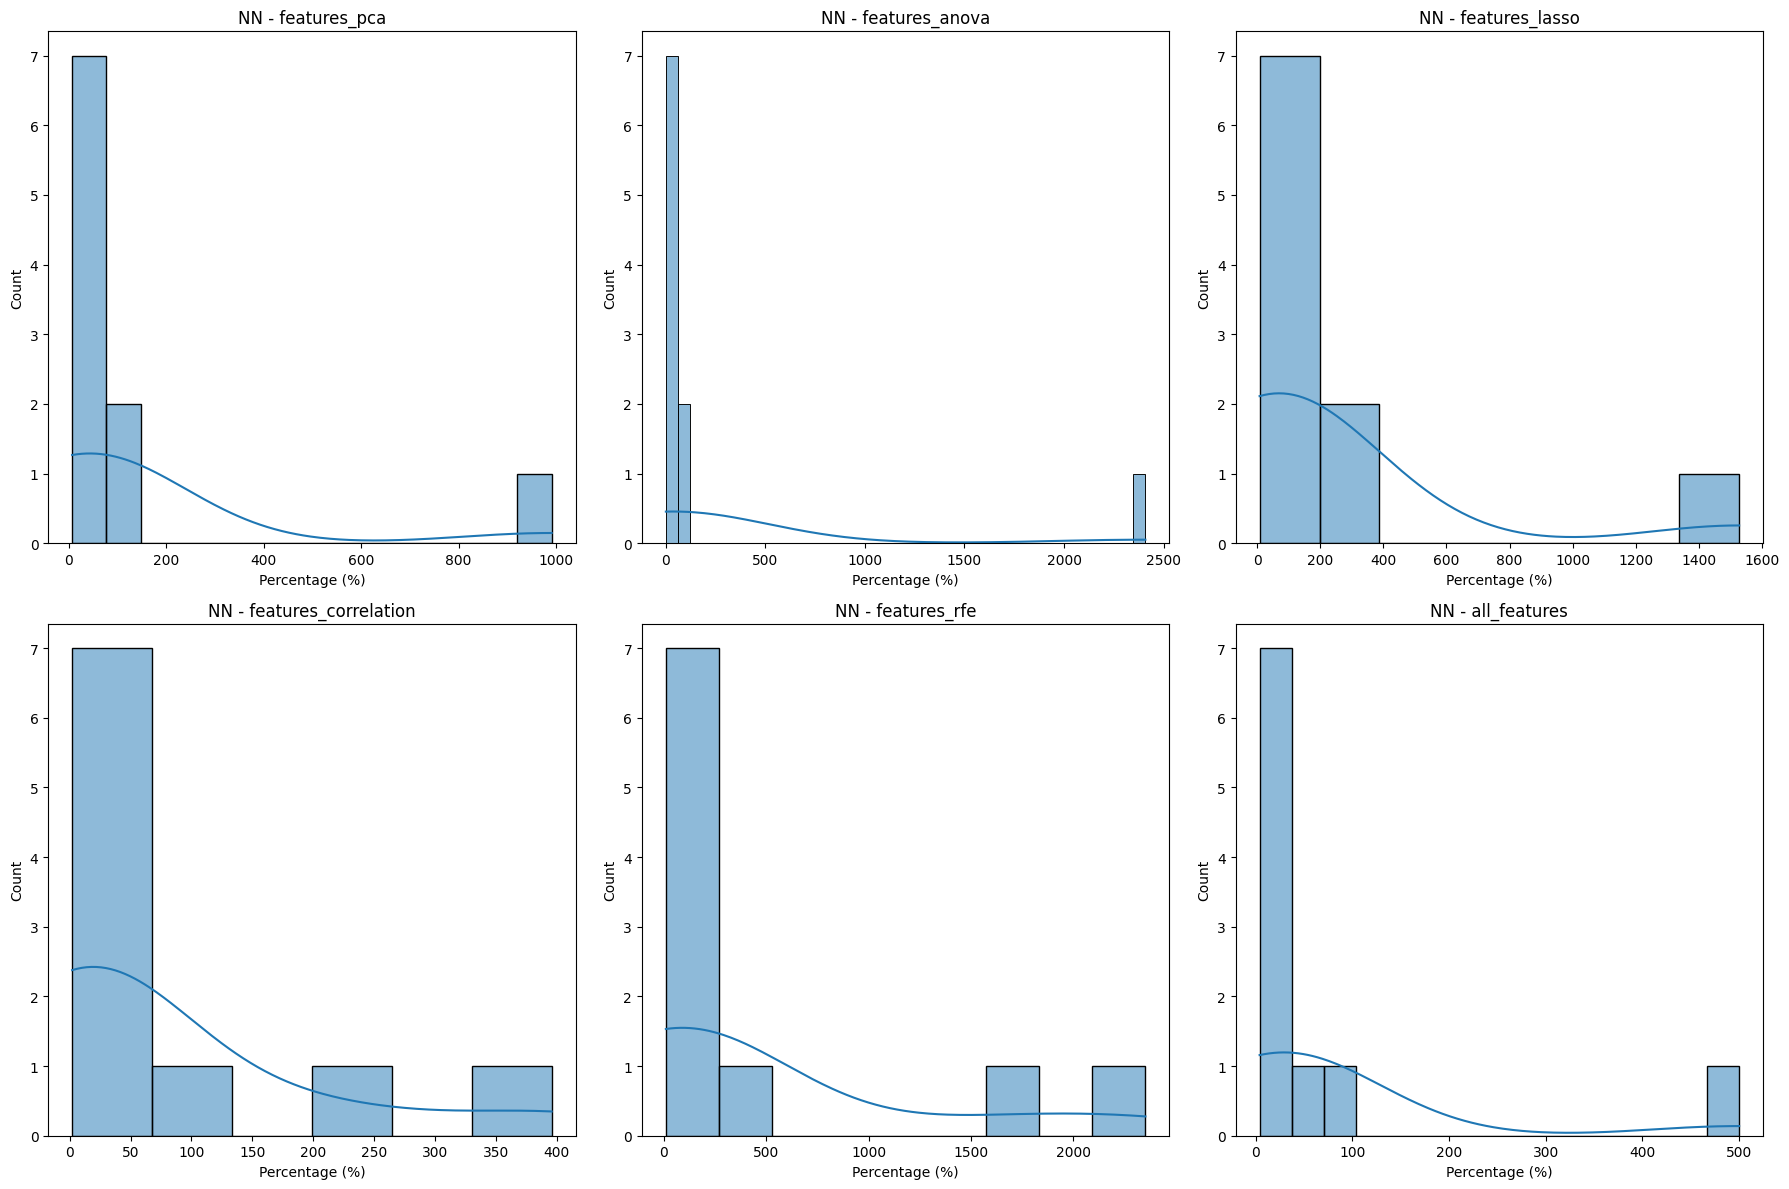

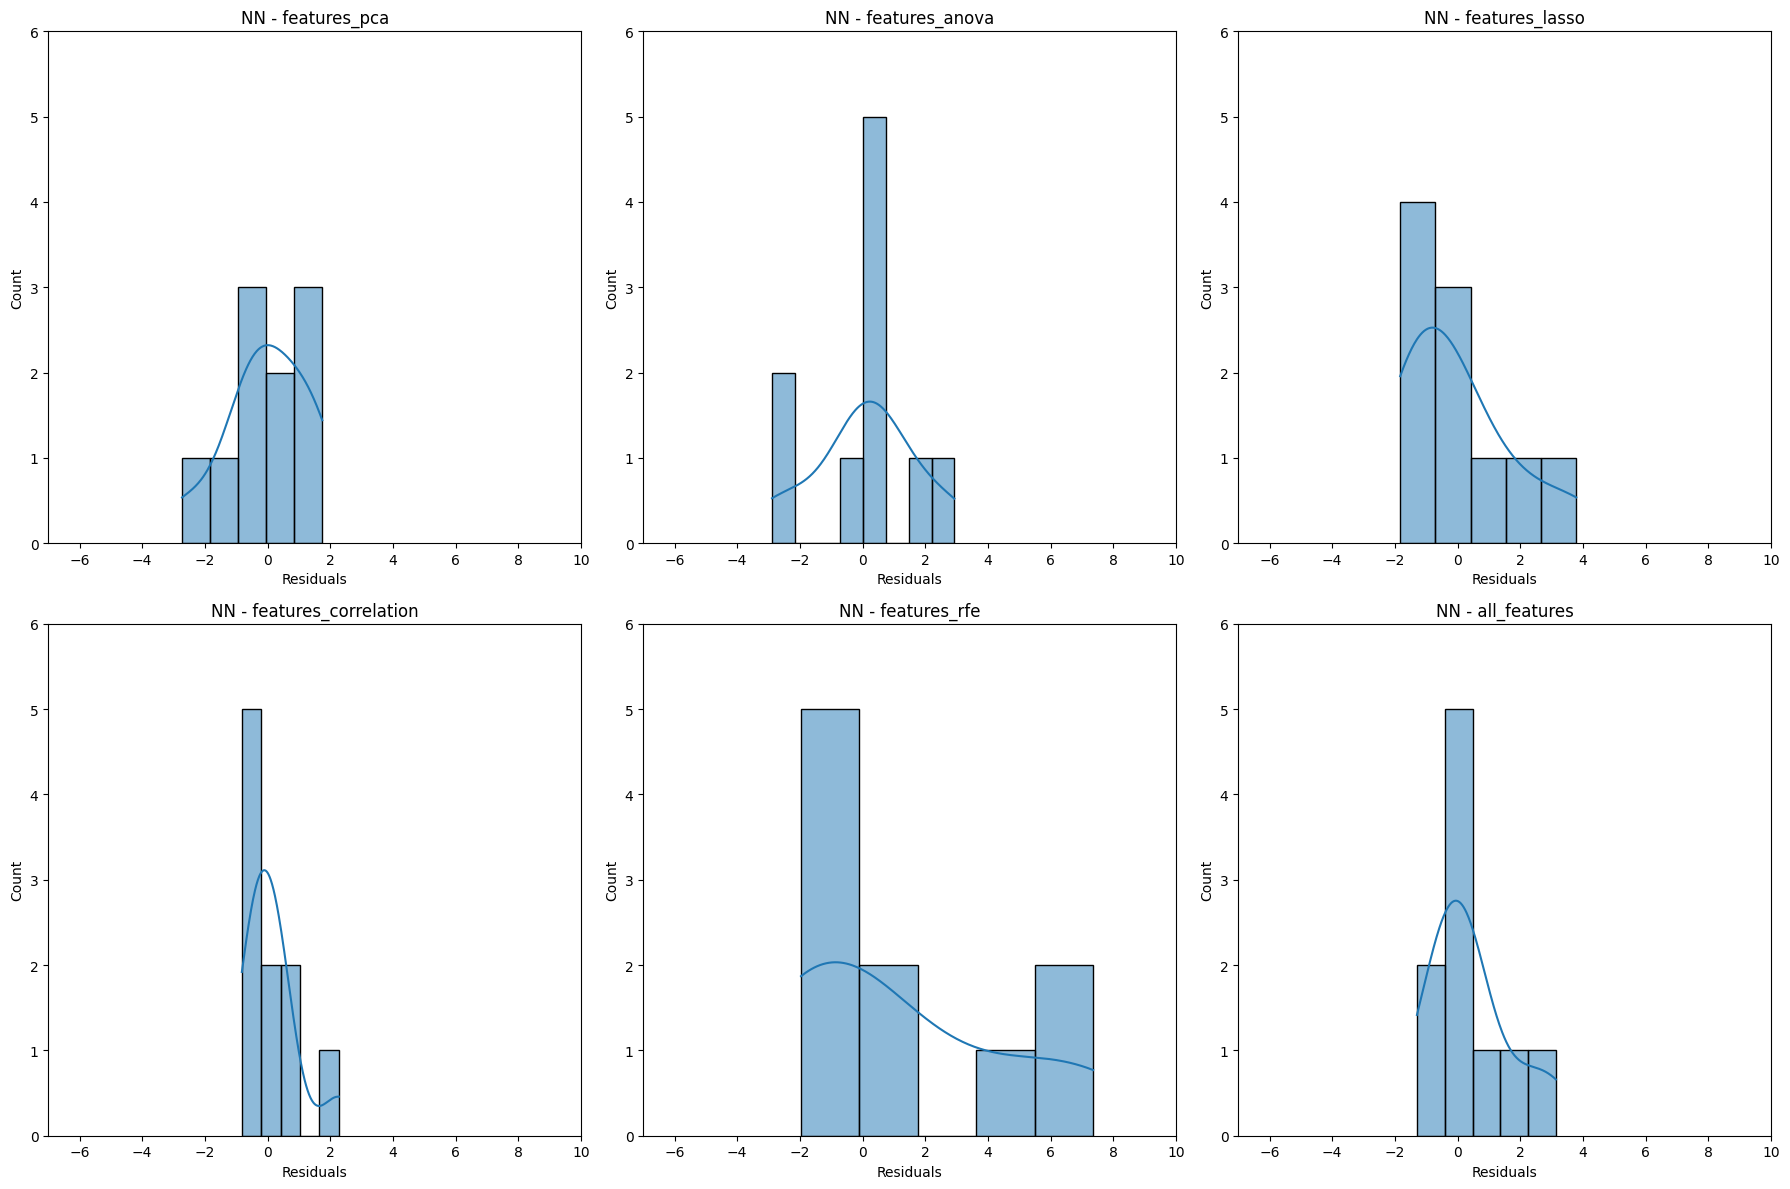

In [32]:
def generate_plots(
    results_test_dict, 
    true_y, 
    target, 
    pred_y, 
    model, 
    save=False, 
    plots_to_generate=None, 
    xlim=None, 
    ylim=None
):
    """
    Generate selected plots for model evaluation with customizable options.

    Parameters:
    - results_test_dict (dict): Dictionary containing test metrics (MSE, MAE, etc.) per feature subset.
    - true_y (array-like): Ground truth values.
    - target (str): Target variable name (e.g., 'Mel_4').
    - pred_y (array-like): Predicted values.
    - model (str): Name of the model (e.g., 'SVR', 'ANN', 'RF').
    - save (bool): Whether to save the plots.
    - plots_to_generate (list): List of plots to generate, options are: 
        ['bar_chart', 'true_vs_pred', 'percentage_histogram', 'residual_histogram'].
    - xlim (tuple): Limits for x-axis in residual histogram (default: None).
    - ylim (tuple): Limits for y-axis in residual histogram (default: None).

    Returns:
    - None
    """

    if plots_to_generate is None:
        plots_to_generate = ['bar_chart', 'true_vs_pred', 'percentage_histogram', 'residual_histogram']

    # Prepare metrics for bar chart if included
    if 'bar_chart' in plots_to_generate:
        results = {}
        filtered_metrics_dict = {k: v for k, v in results_test_dict.items() if 'explained_variance' not in k}

        for key, value in filtered_metrics_dict.items():
            feature, metric = key.rsplit("_", 1)
            if feature not in results:
                results[feature] = [None, None]
            if metric == "MSE":
                results[feature][0] = value
            elif metric == "MAE":
                results[feature][1] = value

        fc.bar_for_metrics(
            dictionary=results, 
            first_label="MSE", 
            second_label="MAE", 
            y_label=f"Feature Subsets for {model}", 
            save=save
        )

    # Generate true vs predicted plot if included
    if 'true_vs_pred' in plots_to_generate:
        fc.plot_y_true_pred(
            true_y=true_y, 
            target=target, 
            pred_y=pred_y, 
            model=model, 
            save=save
        )

    # Generate percentage histogram if included
    if 'percentage_histogram' in plots_to_generate:
        fc.percentage_histogram(
            true_y=true_y, 
            target=target, 
            pred_y=pred_y, 
            model=model, 
            save=save
        )

    # Generate residual histogram if included
    if 'residual_histogram' in plots_to_generate:
        fc.residual_histogram(
            true_y=true_y, 
            target=target, 
            pred_y=pred_y, 
            model=model, 
            xlim=xlim, 
            ylim=ylim, 
            save=save
        )


generate_plots(
    results_test_dict=results_test_ANN, 
    true_y=TEST_Y, 
    target="Mel_4", 
    pred_y=y_pred_ANN_test, 
    model="NN", 
    save="y", 
    plots_to_generate=['bar_chart', 'true_vs_pred', 'residual_histogram',"percentage_histogram"], 
    xlim=(-7, 10), 
    ylim=(0, 6)
)